In [300]:
import pandas as pd 
import os 

from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

import seaborn as sns

from datasets import load_dataset
import numpy as np
import json

In [301]:
pwd

'/home/al2644/research/codebase/reasoning/perturb-r'

In [303]:
cd /home/al2644/research/codebase/reasoning/perturb-r

/home/al2644/research/codebase/reasoning/perturb-r


# Utils

In [3]:
def chunking(model_response, granularity=20):
    """Split thinking into chunks of approximately equal size."""
    # Step 1: merge small chunks
    thinking = model_response.split('</think>')[0]
    chunks = thinking.split('\n\n')
    masks = [len(chunk.split()) > granularity for chunk in chunks]

    merged, buffer = [], []
    for c, m in zip(chunks, masks):
        if not m:
            buffer.append(c)
        else:
            if buffer:
                merged.append('\n\n'.join(buffer))  # Use '\n\n' to maintain paragraph structure
                buffer.clear()
            merged.append(c)
    if buffer:
        merged.append('\n\n'.join(buffer))

    # Step 2: merge small chunks to big chunks
    super_chunks, current = [], None
    for c in merged:
        if len(c.split()) > granularity:
            if current is not None:
                super_chunks.append(current)
            current = c
        else:
            if current is None:
                # no big chunk yet
                current = c
            else:
                current += '\n\n' + c  # Use '\n\n' to maintain paragraph structure

    if current is not None:
        super_chunks.append(current)

    return super_chunks

# Reasoning Results

In [379]:
root = "./results/deepmath_7to9/benchmark"
for fname in os.listdir(root):
    if 'correct' not in fname:
        print(fname)
        df = pd.read_pickle(os.path.join(root, fname))
        print(f"Accuracy: {df['correct'].mean()}")

R1-Distill-Qwen-1.5B.pickle
Accuracy: 0.4706666666666667
R1-Distill-Qwen-7B.pickle
Accuracy: 0.6553333333333333
Qwen3-1.7B.pickle
Accuracy: 0.56
Qwen3-4B.pickle
Accuracy: 0.7246666666666667
Qwen3-1.7B_nothinking.pickle
Accuracy: 0.24133333333333334
Qwen3-4B_nothinking.pickle
Accuracy: 0.3293333333333333
Qwen3-8B.pickle
Accuracy: 0.7453333333333333
Qwen3-8B_nothinking.pickle
Accuracy: 0.3426666666666667
Qwen3-30B-A3B.pickle
Accuracy: 0.7946666666666666
Qwen3-30B-A3B_nothinking.pickle
Accuracy: 0.36933333333333335


In [405]:
df = pd.read_pickle(os.path.join(root, "Qwen3-1.7B.pickle"))
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B")

In [413]:
nothinking_df = pd.read_pickle(os.path.join(root, "Qwen3-1.7B_nothinking.pickle"))

In [401]:
success_df = df[df["correct"]==1.].drop_duplicates(subset="problem")

In [403]:
idx = 0
example = success_df.iloc[0]
problem = example["problem"]
response = example["response"]

In [411]:
convs = [
    {"role": "user", "content": problem}
]
input_str = tokenizer.apply_chat_template(convs, tokenize=False, add_generation_prompt=True, enable_thinking=False)
input_str= input_str.replace("<think>\n\n</think>", "<think>\n" + "wait "*100 + "\n</think>")

In [412]:
print(input_str)

<|im_start|>user
Compute the asymptotic relative efficiency (ARE) for estimating $e^{-
abla}$ in a Poisson process, given by the expression:
$$\text{ARE} = \left[\frac{e^{-\lambda}}{\left(\frac{n-1}{n}\right)^{n\lambda}\log\left( \frac{n-1}{n}\right)^n}\right]^2$$<|im_end|>
<|im_start|>assistant
<think>
wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait 
</think>




In [440]:
df["response"][0]

'<think>\nOkay, so I need to compute the asymptotic relative efficiency (ARE) for estimating the parameter $ e^{-abla} $ in a Poisson process. Wait, hold on, the parameter is written as $ e^{-abla} $? That seems odd. Maybe there\'s a typo? Let me check the original question again.\n\nThe user wrote: "Compute the asymptotic relative efficiency (ARE) for estimating $ e^{-abla} $ in a Poisson process, given by the expression: [expression]". Hmm, maybe "abla" is supposed to be a different symbol? Like maybe a typo for "lambda"? Because in Poisson processes, the intensity is often denoted by $ \\lambda $, and sometimes $ \\lambda $ is used in other contexts. Alternatively, maybe "abla" is a misrendered symbol for something else. Wait, maybe it\'s supposed to be $ \\lambda $, like the rate parameter? Let me think.\n\nIf the parameter is $ e^{-\\lambda} $, then that would make sense. But the question says "estimating $ e^{-abla} $", which is confusing. Maybe "abla" is a typo for "lambda"? If 

In [ ]:
<|im_start|>user
What is 12+130? Please put your final answer in \\boxed{}
<|im_start|>assistant

In [425]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B")
def count_tokens(response, tokenizer=tokenizer):
    return len(tokenizer.encode(response))

In [426]:
df["response_num_tokens"] = df["response"].apply(count_tokens)

<Axes: xlabel='response_num_tokens', ylabel='Count'>

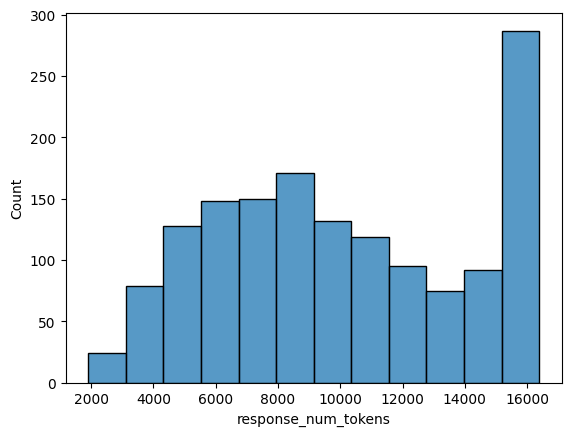

In [427]:
sns.histplot(df["response_num_tokens"])

In [380]:
stress_test_questions = "/home/al2644/research/codebase/reasoning/perturb-r/results/math-500/questions_stress_test_min_correct=3_test_size=200.json"
json.load(open(stress_test_questions))

['test/intermediate_algebra/1247.json',
 'test/intermediate_algebra/1898.json',
 'test/number_theory/488.json',
 'test/prealgebra/1742.json',
 'test/geometry/947.json',
 'test/algebra/841.json',
 'test/algebra/988.json',
 'test/prealgebra/260.json',
 'test/precalculus/477.json',
 'test/algebra/2264.json',
 'test/prealgebra/1458.json',
 'test/intermediate_algebra/991.json',
 'test/counting_and_probability/71.json',
 'test/number_theory/1002.json',
 'test/prealgebra/505.json',
 'test/algebra/1078.json',
 'test/intermediate_algebra/1806.json',
 'test/precalculus/190.json',
 'test/intermediate_algebra/121.json',
 'test/counting_and_probability/1114.json',
 'test/prealgebra/2019.json',
 'test/number_theory/686.json',
 'test/algebra/101.json',
 'test/algebra/224.json',
 'test/precalculus/1172.json',
 'test/algebra/668.json',
 'test/prealgebra/1686.json',
 'test/number_theory/72.json',
 'test/geometry/802.json',
 'test/intermediate_algebra/279.json',
 'test/intermediate_algebra/1126.json',
 '

In [158]:
original_reasoning = df["response"].sample(n=1).iloc[0]
corrupted_reasoning = original_reasoning

In [159]:
numbers = extract_number(corrupted_reasoning)
replacement = {number: perturb_number(number) for number in list(numbers)}

corrupted_reasoning = replace_number(corrupted_reasoning, replacement)

In [161]:
print(original_reasoning)

Alright, so I need to find the units digit of \(18^6\). Hmm, okay. Let me think about how to approach this. I know that when dealing with units digits, especially in problems like this, it's often helpful to look for patterns or cycles in the units digits of powers of the number. 

First, let me recall that the units digit of a number is just the last digit. So, if I have a number like 18, its units digit is 8. Now, when I raise 18 to the power of 6, I'm essentially calculating \(18 \times 18 \times 18 \times 18 \times 18 \times 18\). But multiplying all these together directly would result in a huge number, and I don't need to compute the entire thing. Instead, I can focus on the units digit of each multiplication step because only the units digit affects the final units digit of the product.

So, maybe I can simplify this by just looking at the units digit of 18, which is 8, and then see what happens when I raise 8 to the 6th power. That should give me the same units digit as \(18^6\

In [162]:
print(corrupted_reasoning)

Alright, so I need to find the units digit of \(81^3\). Hmm, okay. Let me think about how to approach this. I know that when dealing with units digits, especially in problems like this, it's often helpful to look for patterns or cycles in the units digits of powers of the number. 

First, let me recall that the units digit of a number is just the last digit. So, if I have a number like 81, its units digit is 5. Now, when I raise 81 to the power of 3, I'm essentially calculating \(81 \times 81 \times 81 \times 81 \times 81 \times 81\). But multiplying all these together directly would result in a huge number, and I don't need to compute the entire thing. Instead, I can focus on the units digit of each multiplication step because only the units digit affects the final units digit of the product.

So, maybe I can simplify this by just looking at the units digit of 81, which is 5, and then see what happens when I raise 5 to the 6th power. That should give me the same units digit as \(81^3\

# Digit Corruption Results

# Chunks

In [198]:
def chunk(reasoning: str, granularity = 20):
    chunks = reasoning.split('\n\n')
    masks = [len(chunk.split()) > granularity for chunk in chunks]

    # Step 1: chunk the sequence into small chunks
    merged, buffer = [], []
    for c, m in zip(chunks, masks):
        if not m:
            buffer.append(c)
        else:
            if buffer:
                merged.append('\n\n'.join(buffer))
                buffer.clear()
            merged.append(c)
    if buffer:
        merged.append('\n\n'.join(buffer))

    # Step 2: merge small chunks to big chunks
    super_chunks, current = [], None
    for c in merged:
        if len(c.split()) > granularity:
            if current is not None:
                super_chunks.append(current)
            current = c
        else:
            if current is None:
                current = c
            else:
                current += '\n\n' + c

    if current is not None:
        super_chunks.append(current)

    return super_chunks

In [352]:
root = "./results/deepmath_7to9/"
os.listdir(root)

['R1-Distill-Qwen-1.5B.pickle',
 'R1-Distill-Qwen-7B.pickle',
 'R1-Distill-Qwen-14B.pickle',
 'R1-Distill-Qwen-32B.pickle',
 'AM-Distill-Qwen-32B.pickle',
 'QwQ-32B.pickle',
 'Qwen3-1.7B.pickle',
 'Qwen3-4B.pickle',
 'Qwen3-8B.pickle',
 'R1-Distill-Qwen3-8B.pickle']

In [377]:
df = pd.read_pickle(os.path.join(root, "Qwen3-1.7B.pickle"))
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B")

In [378]:
tokenizer.apply_chat_template(convs, tokenize=False, add_generation_prompt=True, enable_thinking=False)

'<|im_start|>user\nDefine\n\\[p = \\sum_{k = 1}^\\infty \\frac{1}{k^2} \\quad \\text{and} \\quad q = \\sum_{k = 1}^\\infty \\frac{1}{k^3}.\\]Find a way to write\n\\[\\sum_{j = 1}^\\infty \\sum_{k = 1}^\\infty \\frac{1}{(j + k)^3}\\]in terms of $p$ and $q.$<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n'

In [365]:
sample = df.sample(n=1).iloc[0]
problem = sample["problem"]
response = sample["response"]
reasoning, answer = response.split("</think>")

In [366]:
convs = [{"role": "user", "content": problem}]
input_str = tokenizer.apply_chat_template(convs, tokenize=False, add_generation_prompt=True)
print(input_str)

<|im_start|>user
Define
\[p = \sum_{k = 1}^\infty \frac{1}{k^2} \quad \text{and} \quad q = \sum_{k = 1}^\infty \frac{1}{k^3}.\]Find a way to write
\[\sum_{j = 1}^\infty \sum_{k = 1}^\infty \frac{1}{(j + k)^3}\]in terms of $p$ and $q.$<|im_end|>
<|im_start|>assistant



In [373]:
prompt = input_str+"\n<think>" + "wait " * 100 + "\n</think>"
print(prompt)

<|im_start|>user
Define
\[p = \sum_{k = 1}^\infty \frac{1}{k^2} \quad \text{and} \quad q = \sum_{k = 1}^\infty \frac{1}{k^3}.\]Find a way to write
\[\sum_{j = 1}^\infty \sum_{k = 1}^\infty \frac{1}{(j + k)^3}\]in terms of $p$ and $q.$<|im_end|>
<|im_start|>assistant

<think>wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait wait 
</think>


In [367]:
print(sample["correct"])

1.0


In [374]:
df["response"].apply(count_tokens)

,problem,solution,answer,subject,level,unique_id,response,correct
0,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"<think>\nOkay, so I need to convert the rectan...",1.0
1,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"<think>\nOkay, so I need to convert the rectan...",1.0
2,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"<think>\nOkay, so I need to convert the rectan...",1.0
3,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"<think>\nOkay, so I need to convert the rectan...",1.0
4,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"<think>\nOkay, so I need to convert the rectan...",1.0
...,...,...,...,...,...,...,...,...
2995,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"First, we build a diagram:\n\n[asy]\n\nsize(15...",106^\circ,Geometry,4,test/geometry/615.json,"<think>\nOkay, so I need to find the measure o...",1.0
2996,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"First, we build a diagram:\n\n[asy]\n\nsize(15...",106^\circ,Geometry,4,test/geometry/615.json,"<think>\nOkay, so I need to find the measure o...",1.0
2997,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"First, we build a diagram:\n\n[asy]\n\nsize(15...",106^\circ,Geometry,4,test/geometry/615.json,"<think>\nOkay, so I need to find the measure o...",1.0
2998,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"First, we build a diagram:\n\n[asy]\n\nsize(15...",106^\circ,Geometry,4,test/geometry/615.json,"<think>\nOkay, so I need to find the measure o...",1.0


In [368]:
print(reasoning)

<think>
Okay, so I need to find a way to write the double sum $\sum_{j = 1}^\infty \sum_{k = 1}^\infty \frac{1}{(j + k)^3}$ in terms of $p = \sum_{k = 1}^\infty \frac{1}{k^2}$ and $q = \sum_{k = 1}^\infty \frac{1}{k^3}$. Hmm, let me think about how to approach this.

First, I remember that double sums can sometimes be simplified by changing variables or by relating them to known series. The given sum involves terms $\frac{1}{(j + k)^3}$, so maybe I can make a substitution to simplify the denominator.

Let me consider substituting $n = j + k$. Since both $j$ and $k$ start at 1, the smallest value of $n$ is 2, and as both $j$ and $k$ go to infinity, $n$ also goes to infinity. So, for each $n \geq 2$, how many pairs $(j, k)$ satisfy $j + k = n$?

Well, for a fixed $n$, $j$ can range from 1 to $n - 1$, and $k = n - j$. Therefore, the number of terms for each $n$ is $n - 1$. So, the original double sum can be rewritten as:

$$
\sum_{n = 2}^\infty \sum_{j = 1}^{n - 1} \frac{1}{n^3}
$$

Wait,

In [369]:
print(answer)



To evaluate the double sum

$$
\sum_{j = 1}^\infty \sum_{k = 1}^\infty \frac{1}{(j + k)^3},
$$

we begin by analyzing the structure of the sum. The expression involves terms of the form $\frac{1}{(j + k)^3}$, where both $j$ and $k$ run from 1 to infinity. This suggests that the sum can be reindexed to simplify the expression.

---

### Step 1: Change of Variables

Let us define a new variable $ n = j + k $. Since $ j $ and $ k $ are both at least 1, the smallest possible value of $ n $ is 2, and the largest is unbounded. For each fixed $ n \geq 2 $, the number of pairs $(j, k)$ such that $ j + k = n $ is $ n - 1 $, because $ j $ can range from 1 to $ n - 1 $, and $ k = n - j $.

Thus, we can rewrite the original double sum as:

$$
\sum_{j = 1}^\infty \sum_{k = 1}^\infty \frac{1}{(j + k)^3} = \sum_{n = 2}^\infty \sum_{j = 1}^{n - 1} \frac{1}{n^3}.
$$

---

### Step 2: Simplify the Inner Sum

Now, we can factor out the $ \frac{1}{n^3} $, and the inner sum over $ j $ becomes:

$$
\sum_{

In [205]:
chunks = chunk(reasoning)
n = len(chunks)
unit=0.2
sections = ['\n\n'.join(chunks[int(start_idx * n): int((start_idx + unit) * n)]) for start_idx in np.arange(0, 1, unit)]

In [215]:
prompt = f"The following reasoning trace is for this problem:\n{problem}"
for i in range(len(sections)):
    prompt += f"\n\n#####START OF SECTION {i}\n" +\
        sections[i] +\
        f"\n#####END OF SECTION {i}"

### Corrupt answer digit backwards

In [292]:
from reward_score.math import last_boxed_only_string, remove_boxed

def if_answer (response):
    try:
        math_answer = remove_boxed(last_boxed_only_string(response))
        return True
    except:
        return False
    
def digit_corrupt_analysis (df: pd.DataFrame, cutoffs: list, col: str, stats: str):
    cutoffs.sort()
    final_index = ["< " + str(cutoff) for cutoff in cutoffs] + ['> ' + str(cutoffs[-1])]
    
    def group(col, cutoffs = cutoffs):        
        for cutoff in cutoffs:
            if col < cutoff:
                return f"< {cutoff}"

        return f"> {cutoffs[-1]}"

    df["answer_rate"] = df["post_corruption_response"].apply(if_answer)
    df['group'] = df[col].apply(group)
    
    dist = df['group'].value_counts().loc[final_index]
    perf = df.groupby('group')[stats].mean().loc[final_index]
    answer_rate = df.groupby('group')["answer_rate"].mean().loc[final_index]
    
    return {"num corrupted digits": dist, 
            "answer rate": answer_rate,
            "accuracy": perf
           }

def plot_acc (df: pd.DataFrame, xaxis: str, yaxis: str):
    quantiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
    cutoffs = {q: df[xaxis].quantile(q) for q in quantiles}
    
    def group (v):
        for q in quantiles:
            if v <= cutoffs[q]:
                return q
        return 1.0

    df[f"{xaxis}_quantile"] = df[xaxis].apply(group)

    return df.groupby(f"{xaxis}_quantile")[yaxis].mean()

def corrupt_numbers_analysis (df: pd.DataFrame, corruption_type):
    corrupt_df = df[df['type'] == corruption_type].copy()
    return corrupt_df.groupby("start_pos")["still_correct"].mean()

In [306]:
root = "./results/math-500/corrupt_numbers//"
df = pd.read_pickle(os.path.join(root, 'Qwen3-8B.pickle'))
[fname for fname in os.listdir(root)]

['R1-Distill-Qwen-1.5B.pickle',
 'R1-Distill-Qwen-7B.pickle',
 'Qwen3-1.7B.pickle',
 'Qwen3-4B.pickle',
 'Qwen3-8B.pickle']

In [307]:
df

,problem,solution,answer,subject,level,unique_id,original_response,reasoning_chunks,start_pos,end_pos,prefix_reasoning,corrupted_reasoning,num_prefix_tokens,num_corrupted_tokens,replacement,prompt,type,post_corruption_response,still_correct
0,How many positive whole-number divisors does 1...,First prime factorize $196=2^2\cdot7^2$. The ...,9,Number Theory,3,test/number_theory/572.json,"<think>\nOkay, so I need to figure out how man...","[<think>\nOkay, so I need to figure out how ma...",0.0,0.2,,"<think>\nOkay, so I need to figure out how man...",0,280,"{'2': '1', '196': '619', '1': '4'}",<|im_start|>user\nHow many positive whole-numb...,post_</think>,"619 divided by 1 is 619. Hmm, that's just the ...",1.0
1,How many positive whole-number divisors does 1...,First prime factorize $196=2^2\cdot7^2$. The ...,9,Number Theory,3,test/number_theory/572.json,"<think>\nOkay, so I need to figure out how man...","[<think>\nOkay, so I need to figure out how ma...",0.2,0.4,"<think>\nOkay, so I need to figure out how man...","16 ÷ 0 = 998. Okay, so 0 is a prime factor. No...",280,309,"{'3': '2', '7': '1', '4': '9', '16.333': '1633...",<|im_start|>user\nHow many positive whole-numb...,post_</think>,"0 + 1 = 1, 0 + 1 = 1. 1 * 1 = 1. Wait, that ca...",1.0
2,How many positive whole-number divisors does 1...,First prime factorize $196=2^2\cdot7^2$. The ...,9,Number Theory,3,test/number_theory/572.json,"<think>\nOkay, so I need to figure out how man...","[<think>\nOkay, so I need to figure out how ma...",0.4,0.6,"<think>\nOkay, so I need to figure out how man...","So, for the prime 1, exponent is 1, so 1 + 7 =...",589,301,"{'3': '5', '7': '0', '4': '2', '28': '2', '14'...",<|im_start|>user\nHow many positive whole-numb...,post_</think>,"1, 2, 4, 7, 14, 28, 49, 98, 196. Wait, hold on...",1.0
3,How many positive whole-number divisors does 1...,First prime factorize $196=2^2\cdot7^2$. The ...,9,Number Theory,3,test/number_theory/572.json,"<think>\nOkay, so I need to figure out how man...","[<think>\nOkay, so I need to figure out how ma...",0.6,0.8,"<think>\nOkay, so I need to figure out how man...","Wait, just to make sure I didn't miss any numb...",890,831,"{'11.52': '115.2', '65.333': '65333', '24.5': ...",<|im_start|>user\nHow many positive whole-numb...,post_</think>,"1, 2, 4, 7, 14, 28, 49, 98, 196. \n\nWait, but...",1.0
4,How many positive whole-number divisors does 1...,First prime factorize $196=2^2\cdot7^2$. The ...,9,Number Theory,3,test/number_theory/572.json,"<think>\nOkay, so I need to figure out how man...","[<think>\nOkay, so I need to figure out how ma...",0.8,1.0,"<think>\nOkay, so I need to figure out how man...","Alternatively, if I think about the factors in...",1721,371,"{'4': '3', '7': '1', '28': '8', '14': '41', '9...",<|im_start|>user\nHow many positive whole-numb...,post_</think>,To determine how many **positive whole-number ...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"First, we build a diagram:\n\n[asy]\n\nsize(15...",106^\circ,Geometry,4,test/geometry/615.json,"<think>\nOkay, so I need to find the measure o...","[<think>\nOkay, so I need to find the measure ...",0.0,0.2,,"<think>\nOkay, so I need to find the measure o...",0,814,"{'74': '774', '52': '522', '16': '116', '106':...",<|im_start|>user\nAltitudes $\overline{AD}$ an...,pre_</think>,"<think>\nOkay, let me check that again. If ang...",1.0
1996,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"First, we build a diagram:\n\n[asy]\n\nsize(15...",106^\circ,Geometry,4,test/geometry/615.json,"<think>\nOkay, so I need to find the measure o...","[<think>\nOkay, so I need to find the measure ...",0.2,0.4,"<think>\nOkay, so I need to find the measure o...","Wait, angle BAC is 544°, and angle BAD is 83°,...",814,1579,"{'36': '63', '74': '4', '52': '2', '16': '166'...",<|im_start|>user\nAltitudes $\overline{AD}$ an...,pre_</think>,"<think>\nOkay, so I think I made a mistake ear..

In [308]:
corrupt_numbers_analysis(df, "pre_</think>")

start_pos
0.0    0.990
0.2    1.000
0.4    0.995
0.6    1.000
0.8    1.000
Name: still_correct, dtype: float64

In [309]:
corrupt_numbers_analysis(df, "post_</think>")

start_pos
0.0    0.980
0.2    1.000
0.4    0.990
0.6    0.995
0.8    0.960
Name: still_correct, dtype: float64

In [337]:
idx = 8
example = df[(df["still_correct"] == 1)].iloc[idx]

In [338]:
print(example["problem"])

What is the smallest positive perfect cube that can be written as the sum of three consecutive integers?


In [339]:
print(example["prefix_reasoning"])

<think>
Okay, so I need to find the smallest positive perfect cube that can be written as the sum of three consecutive integers. Hmm, let me think about how to approach this. 

First, let me recall what a perfect cube is. A perfect cube is a number that is the cube of an integer. For example, 1, 8, 27, 64, 125, etc. So, I need to find the smallest one among these that can be expressed as the sum of three consecutive integers. 

Let me start by understanding how to represent three consecutive integers. If I let the middle integer be some number, say, n, then the three consecutive integers would be n-1, n, and n+1. So, their sum would be (n-1) + n + (n+1). Let me compute that. 

Adding them up: (n - 1) + n + (n + 1) = n - 1 + n + n + 1. The -1 and +1 cancel out, so that's 3n. So, the sum of three consecutive integers is 3 times the middle number. 

Wait, so if the sum is 3n, then that means the sum is a multiple of 3. Therefore, any number that can be written as the sum of three consecut

In [340]:
print(example["corrupted_reasoning"])

Next is 2166. 3n = 2166 => n = 27. So integers 1, 27, 3. Let me check their sum: 1 + 27 + 3 = 2166. Yes, that works. So 2166 is also a cube that can be expressed as such. But since 72 is smaller, 72 is the answer. 

But just to make sure, maybe there is a cube between 72 and 2166 that can be expressed as the sum of three consecutive integers? Let's check. 

The cubes between 72 and 2166 are 46, 1125. As checked above, neither of them can be expressed as 3n. So, 72 is the smallest. 

Alternatively, perhaps I made an error in assuming that the sum is 3n. Let me check again. 

Suppose the three consecutive integers are a, a+2, a+8. Their sum is 3a + 1. Which is 1(a + 2). Therefore, the sum is 1 times (a + 2). Therefore, the sum is divisible by 1. Therefore, the cube must be divisible by 1. Therefore, the cube must be 72, 2166, etc. 

Therefore, the answer is 72. 

But let me check again for 72. The three numbers are 6, 0, 110. Their sum is 72. Which is 3³. Yes. 

Alternatively, maybe ther

In [341]:
print(example["post_corruption_response"])

 Let me check if there is a case where the sum is positive. 

Suppose the three numbers are -1, 0, 1. Their sum is 0. Not positive. 

If the numbers are -2, -1, 0. Sum is -3. 

If numbers are -1, 2, 3. Sum is 4. Which is not a cube. 

But if the numbers are 1, 2, 3. Sum is 6. Not a cube. 

2, 3, 4. Sum is 9. Not a cube. 

3, 4, 5. Sum is 12. Not a cube. 

4, 5, 6. Sum is 15. Not a cube. 

5, 6, 7. Sum is 18. Not a cube. 

6, 7, 8. Sum is 21. Not a cube. 

7, 8, 9. Sum is 24. Not a cube. 

8, 9, 10. Sum is 27. Which is 3³. So here we go. 

Therefore, the answer is 27. 

Wait, so earlier I thought that the cube has to be divisible by 3, so the cube is 27, which is 3³. But then why did I think 72? 

Wait, maybe I confused something. Let me retrace. 

Earlier, I thought that the sum of three consecutive integers is 3n, so the cube must be divisible by 3. Therefore, the cube is 3 times something. But since the cube is also a perfect cube, that something must be 3^2 times something else. Wai

# Distraction

## Full distraction

In [303]:
from reward_score.math import last_boxed_only_string, remove_boxed

def if_answer (response):
    try:
        math_answer = remove_boxed(last_boxed_only_string(response))
        return True
    except:
        return False
    
def group_analysis (df: pd.DataFrame, cutoffs: list, col: str, stats: str):
    cutoffs.sort()
    final_index = ["< " + str(cutoff) for cutoff in cutoffs] + ['> ' + str(cutoffs[-1])]
    
    def group(col, cutoffs = cutoffs):        
        for cutoff in cutoffs:
            if col < cutoff:
                return f"< {cutoff}"

        return f"> {cutoffs[-1]}"

    df["answer_rate"] = df["post_distraction_response"].apply(if_answer)
    df['token_count_groups'] = df[col].apply(group)
    
    token_dist = df['token_count_groups'].value_counts().loc[final_index]
    perf = df.groupby('token_count_groups')[stats].mean().loc[final_index]
    answer_rate = df.groupby('token_count_groups')["answer_rate"].mean().loc[final_index]
    
    return {"corrupting token counts": token_dist, 
            "answer rate": answer_rate,
            "accuracy": perf
           }

def token_weighted_backtrack_rate (df: pd.DataFrame):
    original_correct = (df["original_correct"] * df['num_distract_tokens']).mean()
    distractor_correct = (df["distractor_correct"] * df['num_distract_tokens']).mean()
    
    return 

In [304]:
root = './results/hendrycks_math/sample200/distract_thinking'
cutoffs = [500, 1500]
[fname for fname in os.listdir(root) if "inject_user_prompt"  in fname]

['R1-Distill-Qwen-1.5B_inject_user_prompt.pickle',
 'R1-Distill-Qwen-7B_inject_user_prompt.pickle',
 'R1-Distill-Qwen-14B_inject_user_prompt.pickle',
 'R1-Distill-Qwen-32B_inject_user_prompt.pickle',
 'AM-Distill-Qwen-32B_inject_user_prompt.pickle',
 'QwQ-32B_inject_user_prompt.pickle',
 'Qwen3-1.7B_inject_user_prompt.pickle',
 'Qwen3-4B_inject_user_prompt.pickle',
 'Qwen3-8B_inject_user_prompt.pickle',
 'R1-Distill-Qwen3-8B_inject_user_prompt.pickle',
 'Qwen3-30B-A3B_inject_user_prompt.pickle',
 'Qwen3-32B_inject_user_prompt.pickle',
 'R1-Distill-Llama-8B_inject_user_prompt.pickle']

In [322]:
df = pd.read_pickle(os.path.join(root, 'Qwen3-32B_inject_user_prompt.pickle'))

print("accuracy according to original solution: \n", group_analysis(df, cutoffs, "num_distract_tokens", "original_correct"))
print('*' * 50, '\n\n')
print("accuracy according to distractor solution: \n", group_analysis(df, cutoffs, "num_distract_tokens", "distractor_correct"))

accuracy according to original solution: 
 {'corrupting token counts': token_count_groups
< 500     194
< 1500    220
> 1500    486
Name: count, dtype: int64, 'answer rate': token_count_groups
< 500     0.994845
< 1500    0.995455
> 1500    1.000000
Name: answer_rate, dtype: float64, 'accuracy': token_count_groups
< 500     0.412371
< 1500    0.522727
> 1500    0.537037
Name: original_correct, dtype: float64}
************************************************** 


accuracy according to distractor solution: 
 {'corrupting token counts': token_count_groups
< 500     194
< 1500    220
> 1500    486
Name: count, dtype: int64, 'answer rate': token_count_groups
< 500     0.994845
< 1500    0.995455
> 1500    1.000000
Name: answer_rate, dtype: float64, 'accuracy': token_count_groups
< 500     0.577320
< 1500    0.472727
> 1500    0.452675
Name: distractor_correct, dtype: float64}


In [282]:
example = df.sample(n=1).iloc[0]
print("Original Correct?: ", example["original_correct"], "Distractor Correct?: ", example["distractor_correct"])
print(example["problem"], "\n\n", "=" * 100)
print(example["distract_reasoning"], "\n\n", "=" * 100)
print(example["post_distraction_response"])

Original Correct?:  0.0 Distractor Correct?:  1.0
<｜begin▁of▁sentence｜><｜User｜>A regular tetrahedron is a pyramid with four faces, each of which is an equilateral triangle.

Let $ABCD$ be a regular tetrahedron and let $P$ be the unique point equidistant from points $A,B,C,D$. Extend $\overrightarrow{AP}$ to hit face $BCD$ at point $Q$. What is the ratio $PQ/AQ$ ?<｜Assistant｜><think>
 

Alright, so I need to find the midpoint of the line segment connecting points P(5,3) and Q(-3,6). Hmm, okay, midpoints. I remember that the midpoint formula is something like taking the average of the x-coordinates and the average of the y-coordinates of the two points. Let me try to recall the exact formula.

I think it's ( (x1 + x2)/2 , (y1 + y2)/2 ). Yeah, that seems right. So, for points P(x1, y1) and Q(x2, y2), the midpoint M is given by M = ( (x1 + x2)/2 , (y1 + y2)/2 ). Okay, so let's plug in the values from points P and Q.

Point P is (5,3), so x1 is 5 and y1 is 3. Point Q is (-3,6), so x2 is -3 

In [256]:
print("Original Solution: ", example["solution"], "\n\n", "=" * 100)
print("Distractor Solution: ", example["distract_solution"])

Original Solution:  Let $r$ and $s$ be the $x$-coordinates of the two points of tangency.  As such, they will be double roots of the polynomial
\[(x^4 + ax^3 + x^2 + bx + 1) - x^2 = x^4 + ax^3 + bx + 1.\]Hence,
\begin{align*}
x^4 + ax^3 + bx + 1 &= (x - r)^2 (x - s)^2 \\
&= (x^2 - 2rx + r^2)(x^2 - 2sx + s^2) \\
&= x^4 - (2r + 2s) x^3 + (r^2 + 4rs + s^2) x^2 - (2r^2 s + 2rs^2) x + r^2 s^2.
\end{align*}Matching coefficients, we get
\begin{align*}
r^2 + 4rs + s^2 &= 0, \\
r^2 s^2 &= 1.
\end{align*}From $r^2 s^2 = 1,$ either $rs = 1$ or $rs = -1.$  But $4rs = -(r^2 + s^2)$ is nonpositive, so $rs = -1.$  Then
\[r^2 + s^2 = 4.\]Hence, $(r - s)^2 = r^2 - 2rs + s^2 = 6,$ so $|r - s| = \boxed{\sqrt{6}}.$ 

Distractor Solution:  The GCD of 840, 960, and 1200 is 120. Since 120 has 16 positive divisors, 840, 960, and 1200 have $\boxed{16}$ common positive divisors.


# Midway distraction

### Todo:
1. The distraction at start is a special case of midway distraction
2. refractor the code to include both

In [180]:
root = './results/hendrycks_math/sample200/distract_thinking'
cutoffs = [.5, 1.0]
[fname for fname in os.listdir(root) if "midway" in fname]

['R1-Distill-Qwen-1.5B_midway.pickle',
 'R1-Distill-Qwen-7B_midway.pickle',
 'R1-Distill-Qwen-14B_midway.pickle',
 'R1-Distill-Llama-8B_midway.pickle',
 'QwQ-32B_midway.pickle',
 'Qwen3-1.7B_midway.pickle',
 'Qwen3-4B_midway.pickle',
 'Qwen3-8B_midway.pickle',
 'R1-Distill-Qwen3-8B_midway.pickle']

In [260]:
df = pd.read_pickle(os.path.join(root, "QwQ-32B_midway.pickle"))
df["original/distract ratio"] = df["num_original_reasoning_prefix_tokens"] / df["num_distract_tokens"]
print("accuracy according to original solution: \n", group_analysis(df, cutoffs, "original/distract ratio", "original_correct"))
print('*' * 50, '\n\n')
print("accuracy according to distractor solution: \n", group_analysis(df, cutoffs, "original/distract ratio", "distractor_correct"))


KeyError: "['< 1500', '> 1500'] not in index"

In [189]:
print(df["post_distraction_response"][100])

 

To find the extrema, we can take the derivative of f(x) and set it equal to zero. Let me compute f'(x):

f'(x) = derivative of arctan(x) + (1/2) derivative of arcsin(x).

The derivative of arctan(x) is 1/(1 + x²). 

The derivative of arcsin(x) is 1 / sqrt(1 - x²), so (1/2) times that is 1/(2 sqrt(1 - x²)).

Therefore:

f'(x) = 1/(1 + x²) + 1/(2 sqrt(1 - x²)).

Wait, but hold on. The problem is asking for the range of this function. Hmm, but maybe instead of calculus, I can find some substitution or identity that can help here? Let me think.

Alternatively, perhaps using calculus is the way to go. Let me proceed with calculus.

First, let's note that f(x) is defined on [-1, 1]. Let's compute f at the endpoints first:

At x = 1:

arctan(1) = π/4,

arcsin(1) = π/2,

so f(1) = π/4 + (1/2)(π/2) = π/4 + π/4 = π/2.

At x = -1:

arctan(-1) = -π/4,

arcsin(-1) = -π/2,

so f(-1) = -π/4 + (1/2)(-π/2) = -π/4 - π/4 = -π/2.

Hmm, interesting. So at the endpoints, we get π/2 and -π/2. But since f(

In [267]:
df["problem"][0]

'<|im_start|>user\nA target consists of four concentric circles with radii 4 inches, 6 inches, 8 inches and 10 inches as shown. Given that a dart is thrown that hits the target at a random point, what is the probability that it hits a shaded region? Express your answer as a common fraction.\n\n[asy]size(100); import graph; fill(Circle((0,0),5),gray(.6));\n\nclip(Circle((0,0),2) ^^ Circle((0,0),3) ^^ Circle((0,0),4),fillrule(1));\ndraw(Circle((0,0),2) ^^ Circle((0,0),3) ^^ Circle((0,0),4) ^^ Circle((0,0),5));[/asy]<|im_end|>\n<|im_start|>assistant\n<think>\n'

In [269]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/QwQ-32B")

In [191]:
print(df["distract_reasoning"][100])

Okay, so I have this problem here: The parabola y = x² is tangent to the graph of y = x⁴ + a x³ + x² + b x + 1 at two points. I need to find the positive difference between the x-coordinates of these points of tangency. Hmm, okay. Let's see. 

First, since the two graphs are tangent to each other at two points, that means they not only intersect at those points but also share a common tangent line there. So, at the points of tangency, both the functions and their derivatives must be equal. That gives me a system of equations to work with. 

Let me denote the points of tangency as (s, s²) and (t, t²). Since these points lie on both curves, substituting into both equations should satisfy them. 

So for each point, say (s, s²), substituting into the quartic equation gives:

s² = s⁴ + a s³ + s² + b s + 1.

Wait, if I subtract s² from both sides, that cancels out the s² terms. So we get:

0 = s⁴ + a s³ + 0 s² + b s + 1.

Hmm, so that simplifies to s⁴ + a s³ + b s + 1 = 0.

Similarly, for th

In [295]:
df["problem"]

0      <|im_start|>user\nWhat is the sum of all the p...
1      <|im_start|>user\nWhat is the sum of all the p...
2      <|im_start|>user\nWhat is the sum of all the p...
3      <|im_start|>user\nWhat is the sum of all the p...
4      <|im_start|>user\nWhat is the sum of all the p...
                             ...                        
915    <|im_start|>user\nA palindrome is a number tha...
916    <|im_start|>user\nA palindrome is a number tha...
917    <|im_start|>user\nA palindrome is a number tha...
918    <|im_start|>user\nA palindrome is a number tha...
919    <|im_start|>user\nA palindrome is a number tha...
Name: problem, Length: 920, dtype: object

In [176]:
pos = list(range(0, 120, 20)) 

In [182]:
from itertools import product
pairs = [(x, x+y )for x, y in list(product(pos, pos)) if (x+y)<=100 and y!=0]

In [189]:
random.sample(pairs, 5)

[(60, 100), (20, 80), (20, 40), (0, 80), (20, 60)]

In [190]:
df

,problem,solution,answer,subject,level,unique_id,response,correct,response_num_tokens
0,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"Okay, so I need to convert the rectangular coo...",1.0,1476
1,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"Okay, so I have to convert the point (0, 3) fr...",1.0,1109
2,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"Okay, so I need to convert the rectangular coo...",1.0,1167
3,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"Okay, so I have this problem where I need to c...",1.0,1431
4,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json,"Alright, so I need to convert the rectangular ...",1.0,1525
...,...,...,...,...,...,...,...,...,...
2995,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"First, we build a diagram:\n\n[asy]\n\nsize(15...",106^\circ,Geometry,4,test/geometry/615.json,"Alright, so I have this geometry problem here,...",1.0,2713
2996,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"First, we build a diagram:\n\n[asy]\n\nsize(15...",106^\circ,Geometry,4,test/geometry/615.json,"Alright, so I have this geometry problem here....",1.0,8087
2997,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"First, we build a diagram:\n\n[asy]\n\nsize(15...",106^\circ,Geometry,4,test/geometry/615.json,"Alright, so I have this geometry problem here,...",1.0,6253
2998,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"First, we build a diagram:\n\n[asy]\n\nsize(15...",106^\circ,Geometry,4,test/geometry/615.json,"Okay, so I have this geometry problem here. It...",1.0,3916


we inspect the local behaviors of reasoning model. reasoning is the ability to draw logical inference from prior proven conclusions. a true reasoner should care about the consistency of logical steps and if there is an error made before, one should review it. we don't know if reasoning efforts are consistent througout its thinking and answering. in addition, we also don't know when they verify/ check previous thinking, how far do they check the reasoning. do they only look for global errors etc. lastly, how do human thinking influence model thinking. will useful human thinking save model reasoning effort. will flaws in human thinking be detected and corrected?

scores on standard benchmark 1. only a aggregated view of reasoning capability 2. does not offer detailed analysis for how and where reasoning efforts are applied. in addition, given the possibility of data containiation, it is criticial to design stress tests to probe model's reasoning behaviors in special cases